In [27]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
#

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF
from pbcpy.local_functionals_utils import x_TF_y_vW 
from pbcpy.nonlocal_functionals_utils import LindhardFunction, MGP_kernel, WT_kernel
from pbcpy.local_pseudopotential import NuclearElectron
from pbcpy.hartree import HartreeFunctional

In [29]:
def data_read(i):
    print(i)
    density = PP('../../Densities2/Al_'+str(i)+'_0_fde_0rho.pp').read()
    kin_pot = PP('../../Potentials2/Al_'+str(i)+'_0_vt_rhotot_alph.pp').read()
    density =density.field
    kin_pot =kin_pot.field/2.
#    ThomasFermi = Functional(name='TF',energydensity=ThomasFermiEnergy(data_dens), potential=ThomasFermiPotential(data_dens))
#    vonWeizsacker = Functional(name='vW',energydensity=vonWeizsackerEnergy(data_dens), potential=vonWeizsackerPotential(data_dens,Sigma=0.1))
    ThomasFermi = Functional(name='TF',energydensity=ThomasFermiEnergy(density), potential=ThomasFermiPotential(density))
    vonWeizsacker = Functional(name='vW',energydensity=vonWeizsackerEnergy(density), potential=vonWeizsackerPotential(density,Sigma=0.1))
    
    potential = kin_pot
    #potential_NL = kin_pot - ThomasFermi.potential - vonWeizsacker.potential
    return density, potential


#first input adds 1, second input adds 10 lines, third input adds 500 lines

In [30]:
# Initializing arrays which are going to be filled with the data

# in data_pot we store the nonlocal part of the potential
data_dens = []
data_pot = []
for j in range(1,11):
    density,potential = data_read(j)
    data_dens.append(density) 
    data_pot.append(potential)
print(np.shape(data_dens))
print(np.shape(data_pot))

1
2
3
4
5
6
7
8
9
10
(10, 50, 50, 50, 1)
(10, 50, 50, 50, 1)


In [31]:
dens = np.empty(0)
#for i in data_dens:
   # for j in i:
       # for k in j:
dens = np.append(dens, [data_dens])
print(dens)

print(np.shape(dens))
 

[0.03834769 0.03818566 0.03755185 ... 0.01672162 0.01631855 0.01584975]
(1250000,)


In [32]:
pot = np.empty(0)

#for i in data_pot:
 #   for j in i:
  #      for k in j:
   #         for l in k:
    #            for m in l:
pot = np.append(pot, [data_pot])
print(pot)
print(np.shape(pot))

[0.57238696 0.56907503 0.56034242 ... 0.31827583 0.31159472 0.30405603]
(1250000,)


In [33]:
dens1 = dens.reshape(-1,1)
pot1 = pot.reshape(-1,1)
print(np.shape(dens1))
print(np.shape(pot1))

(1250000, 1)
(1250000, 1)


In [34]:
dens_train = dens1[0:8000]
dens_test = dens1[8000:10000]
pot_train = pot1[0:8000]
pot_test = pot1[8000:10000]

In [10]:
#dens_train1 = dens_train.reshape(1,-1)
#dens_test1=dens_test.reshape(1,-1)
#pot_train1 = pot_train.reshape(1,-1)
#pot_test1=pot_test.reshape(1,-1)

In [35]:
from sklearn.neural_network import MLPRegressor

In [86]:
n_layer = [(8,), (10,), (12,)]
solve = ['adam','lbfgs', 'sgd']
alpha = [0.01, 0.001, 0.0001]
score_array_2 = np.zeros((len(solve),len(n_layer),len(alpha)))
inner = 0
inner2 = 0
inner3 = 0
for j in n_layer:
    inner2 = 0
    for i in solve:
        inner3 = 0
        for h in alpha:
            modelnn = MLPRegressor(hidden_layer_sizes= j, alpha = h, solver = i)
            modelnn.fit(dens_train, np.ravel(pot_train))
            predict_nn = modelnn.predict(dens_test)
            score = 0.1*(1/2000)*np.sum(np.abs((predict_nn[:]-pot_test[:])/pot_test[:]))
            print('n_layer: ',j,'solver: ',i, 'alpha:', h, 'score: ',score)
            score_array_2[inner][inner2][inner3] = score
            print (score_array_2[inner][inner2][inner3])
            inner3 +=1
        inner2 += 1
    inner += 1

n_layer:  (8,) solver:  adam alpha: 0.01 score:  119.85708814080402
119.85708814080402
n_layer:  (8,) solver:  adam alpha: 0.001 score:  119.95774378647828
119.95774378647828
n_layer:  (8,) solver:  adam alpha: 0.0001 score:  120.25029934200056
120.25029934200056
n_layer:  (8,) solver:  lbfgs alpha: 0.01 score:  161.33805754014597
161.33805754014597
n_layer:  (8,) solver:  lbfgs alpha: 0.001 score:  161.48234513548175
161.48234513548175
n_layer:  (8,) solver:  lbfgs alpha: 0.0001 score:  161.46704654628485
161.46704654628485
n_layer:  (8,) solver:  sgd alpha: 0.01 score:  118.5573054079227
118.5573054079227
n_layer:  (8,) solver:  sgd alpha: 0.001 score:  119.5551703274994
119.5551703274994
n_layer:  (8,) solver:  sgd alpha: 0.0001 score:  119.76483885179464
119.76483885179464
n_layer:  (10,) solver:  adam alpha: 0.01 score:  149.65850971341484
149.65850971341484
n_layer:  (10,) solver:  adam alpha: 0.001 score:  151.7222029408748
151.7222029408748
n_layer:  (10,) solver:  adam alpha: 

adam (8,) [119.85708814 119.95774379 120.25029934]
adam (10,) [161.33805754 161.48234514 161.46704655]
adam (12,) [118.55730541 119.55517033 119.76483885]
lbfgs (8,) [149.65850971 151.72220294 146.18190975]
lbfgs (10,) [161.59963213 161.79532776 162.34088459]
lbfgs (12,) [119.83386123 119.11960884 119.67903151]
sgd (8,) [120.86571446 152.1085593  120.5894752 ]
sgd (10,) [161.19835874 162.1733041  161.2704819 ]
sgd (12,) [118.58484569 119.30835229 119.1562708 ]


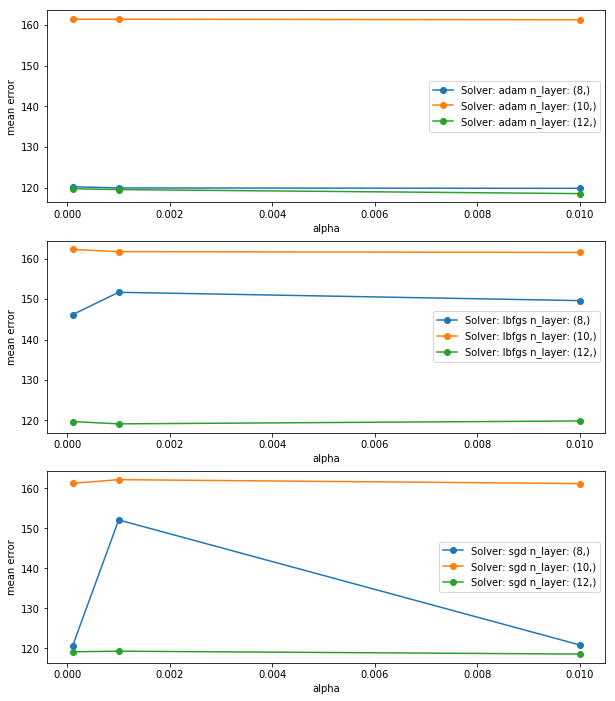

In [87]:
#plotting the mean error
mpl.rcParams['figure.figsize'] = (10,12)
fig, axes = plt.subplots(nrows=3,ncols=1)
for i in range(len(solve)):
    for j in range(len(n_layer)):
        print (solve[i],n_layer[j], score_array_2[i][j])
        axes[i].plot(alpha,score_array_2[i][j],label = 'Solver: '+solve[i]+' n_layer: '+str(n_layer[j]), marker = 'o')
        axes[i].set_xlabel('alpha')
        axes[i].set_ylabel('mean error')
        axes[i].legend()
plt.show()
#np.ravel(TF[0:8000])

In [88]:
#figuring out which point yields the lowest mean error
model_adam = MLPRegressor(solver = 'adam', hidden_layer_sizes = 10, alpha = .1)
model_lbfgs = MLPRegressor(solver = 'lbfgs', hidden_layer_sizes = 10, alpha = .1)
model_sgd = MLPRegressor(solver = 'sgd', hidden_layer_sizes = 10, alpha = 0)

#fitting the solvers to the data
model_adam.fit(dens_train, np.ravel(pot_train))
model_lbfgs.fit(dens_train, np.ravel(pot_train))
model_sgd.fit(dens_train, np.ravel(pot_train))

pred_adam = model_adam.predict(dens_test)
pred_lbfgs = model_lbfgs.predict(dens_test)
pred_sgd = model_sgd.predict(dens_test)

import matplotlib.pyplot as plt

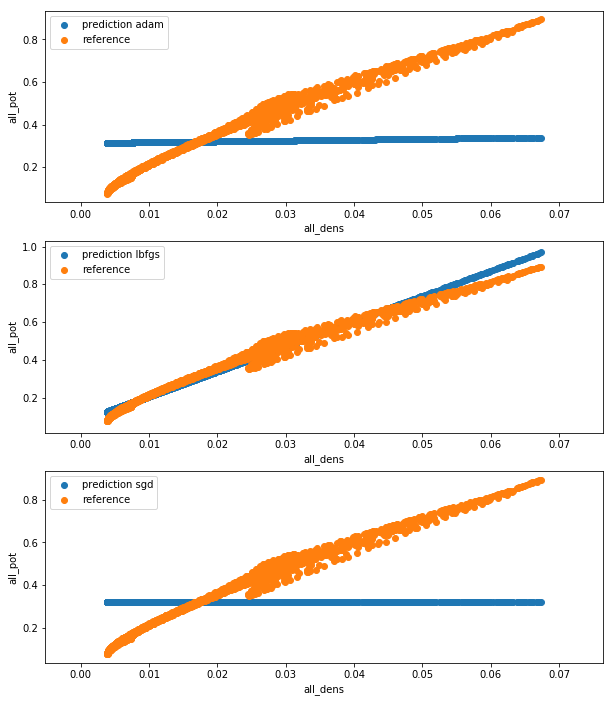

In [89]:
#seeing how accurate the prediction is
fig, axes = plt.subplots(nrows=3,ncols=1)

axes[0].scatter(dens_test, pred_adam, label = 'prediction adam')
axes[0].scatter(dens_test, pot_test, label = 'reference')

axes[1].scatter(dens_test, pred_lbfgs, label = 'prediction lbfgs')
axes[1].scatter(dens_test, pot_test, label = 'reference')

axes[2].scatter(dens_test, pred_sgd, label = 'prediction sgd')
axes[2].scatter(dens_test, pot_test, label = 'reference')

#axes[3].scatter()

for i in range(3):
    axes[i].set_xlabel('all_dens')
    axes[i].set_ylabel('all_pot')
    axes[i].legend()
    
plt.show()